In [6]:
env = 'colab'  # 'colab' or 'pc'

using_gpu = False  # True

train_percentage = 0.1  # how much of train set we will use
val_percentage = 0.1
test_percentage = 0.1

saving_models = True
saving_metrics_report = True
n_trial = 1

git_download_path = 'https://github.com/PashaIanko/Covid19Classifier/tree/model_agility/'

# Number of trial for this day (-> directory/24-01-22/trial-{n_trial}/ -- example of directories)

# Packages & functions

In [12]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}

if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    
    files = [
            'DataProperties.py',
            'DatasetParameters.py',
            'Preprocessing.py',
            'PreprocessingParameters.py',
            
            'Utils.py',
             
            'BNModel.py',
            'CNNModel.py',
            'DropoutModel.py',
            'InceptionModel.py',
            'Model.py',
            'ResNetModel.py',
            'ModelUtils.py'
    ]
    url_dict = {file: git_download_path + file for file in files}
    download_files(url_dict)

In [8]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from os import listdir

In [9]:
# Models
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D as Conv2D
from tensorflow.keras.layers import BatchNormalization as BatchNormalization
from tensorflow.keras.layers import ReLU as ReLU
from tensorflow.keras.layers import MaxPool2D as MaxPool2D
from tensorflow.keras.layers import Flatten as Flatten
from tensorflow.keras.layers import Dense as Dense
from tensorflow.keras.layers import Input as Input

from os.path import isdir
import os
import numpy as np

# Plotting
import seaborn as sns

# Utils
import importlib
from os.path import isdir
from datetime import date
import pandas as pd

# Dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
import DataProperties 
import PreprocessingParameters 
import Preprocessing
import DatasetParameters
import Utils
import CNNModel
import BNModel
import ResNetModel
import DropoutModel
import InceptionModel
import Model
import ModelUtils

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        DataProperties,
        PreprocessingParameters,
        DatasetParameters,
        Utils,
        Preprocessing,
        CNNModel,
        BNModel,
        DropoutModel,
        Model,
        ResNetModel,
        InceptionModel,
        ModelUtils
    ]
)

from DataProperties import DataProperties
from PreprocessingParameters import PreprocessingParameters
from DatasetParameters import DatasetParameters
from Utils import *
from Preprocessing import *
from CNNModel import CNNModel
from BNModel import BNModel
from DropoutModel import DropoutModel
from ResNetModel import ResNetModel
from InceptionModel import InceptionModel
from ModelUtils import ModelUtils

SyntaxError: ignored

In [ ]:
DataProps = DataProperties(
    environment = env,
    n_trial = n_trial
)

# Data download

## Paths download

In [ ]:
assert isdir(DataProps.train_data_path) == True
assert isdir(DataProps.test_data_path) == True
assert isdir(DataProps.val_data_path) == True
assert isdir(DataProps.models_path) == True

In [ ]:
train_files = calc_files(directory = DataProps.train_data_path)
train_covid_files = calc_files(DataProps.train_covid_path)
train_pn_files = calc_files(DataProps.train_pneumonia_path)
train_healthy_files = calc_files(DataProps.train_healthy_path)

assert train_files == (train_covid_files + train_pn_files + train_healthy_files)

In [ ]:
val_files = calc_files(directory = DataProps.val_data_path)
val_covid_files = calc_files(DataProps.val_covid_path)
val_pn_files = calc_files(DataProps.val_pneumonia_path)
val_healthy_files = calc_files(DataProps.val_healthy_path)

assert val_files == (val_covid_files + val_pn_files + val_healthy_files)

In [ ]:
test_files = calc_files(DataProps.test_data_path)
test_covid_files = calc_files(DataProps.test_covid_path)
test_pn_files = calc_files(DataProps.test_pneumonia_path)
test_healthy_files = calc_files(DataProps.test_healthy_path)

assert test_files == (test_covid_files + test_pn_files + test_healthy_files)

In [ ]:
x = ['T', 'V', 'Test']
y = [train_files, val_files, test_files]

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ax.bar(x, y, width, color="blue")
plt.title('Data split')
plt.xlabel('Data set')
plt.ylabel('y') 

In [ ]:
train_covid_files, train_healthy_files, train_pn_files

In [ ]:
val_covid_files, val_healthy_files, val_pn_files

In [ ]:
test_covid_files, test_healthy_files, test_pn_files

In [ ]:
train_files + val_files + test_files

# Creating dataset

## Train

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function = Preprocessing.normalize,
    validation_split = 1 - train_percentage
    # width_shift_range = 4,
    # height_shift_range = 4,
    # horizontal_flip = True,
    # vertical_flip = True
)

train_flow = train_generator.flow_from_directory(
    directory = DataProps.train_data_path,
    target_size = PreprocessingParameters.target_shape,
    color_mode = 'rgb',
    classes = DataProperties.classes,
    class_mode = 'sparse',  # 1D integer labels
    batch_size = DatasetParameters.batch_size,
    subset = 'training',
    shuffle = DatasetParameters.shuffle_train,
    seed = DatasetParameters.seed
)
print(f'Use {train_flow.n} images for train')

## Validation

In [ ]:
val_generator = ImageDataGenerator(
    preprocessing_function = Preprocessing.normalize,
    validation_split = 1 - val_percentage
    # width_shift_range = 4,
    # height_shift_range = 4,
    # horizontal_flip = True,
    # vertical_flip = True
)

val_flow = train_generator.flow_from_directory(
    directory = DataProps.val_data_path,
    target_size = PreprocessingParameters.target_shape,
    color_mode = 'rgb',
    classes = DataProperties.classes,
    class_mode = 'sparse',  # 1D integer labels
    batch_size = DatasetParameters.batch_size,
    subset = 'training',  # yes, training - we use val_split of data 
    shuffle = DatasetParameters.shuffle_validation,
    seed = DatasetParameters.seed
)

print(f'Use {val_flow.n} images for validation')

## Test

In [ ]:
test_generator = ImageDataGenerator(
    preprocessing_function = Preprocessing.normalize,
    validation_split = 1 - test_percentage
    # other parameters
)

test_flow = test_generator.flow_from_directory(
    directory = DataProps.test_data_path,
    target_size = PreprocessingParameters.target_shape,
    color_mode = 'rgb',
    classes = DataProperties.classes,
    class_mode = 'sparse',
    shuffle = DatasetParameters.shuffle_test,
    seed = DatasetParameters.seed,
    batch_size = 1,
    subset = 'training'
)

print(f'Use {test_flow.n} images for test')

In [ ]:
assert train_flow.class_indices == test_flow.class_indices
assert train_flow.class_indices == val_flow.class_indices

# Visualizing dataset

In [ ]:
how_many_to_show = 9
for _ in range(1):
    batch, labels = train_flow.next()
    print(batch.shape)
    assert np.max(batch) <= 1.0
    visualize(batch, labels, how_many_to_show)

# Fitting models

## Prepare

In [ ]:
train_steps = train_flow.n // train_flow.batch_size
validation_steps = val_flow.n // val_flow.batch_size
test_steps = test_flow.n // test_flow.batch_size

what_to_monitor = 'val_loss'
validation_data = val_flow
validation_steps = validation_steps

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor = what_to_monitor,
    patience = 2,  # 3
    mode = 'auto',
    restore_best_weights = True
)

print(f'Train steps: {train_steps}')
print(f'Val steps: {validation_steps}')

In [ ]:
if using_gpu:
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        print(
            '\n\nThis error most likely means that this notebook is not '
            'configured to use a GPU.  Change this in Notebook Settings via the '
            'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
        raise SystemError('GPU device not found')

## Fit

In [ ]:
CNNUtils = ModelUtils(

    model_params_dict = dict(
        optimizer = 'adam',
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
        metrics = ['acc'] 
    ),

    checkpoint_params_dict = dict(
        filepath = f'{DataProps.checkpoint_path}CNN/',
        save_weights_only=True,
        monitor = 'val_acc',
        mode='max',
        save_best_only = True
    ),

    train_params_dict = dict(
        train_flow = train_flow,
        train_steps = train_steps,

        val_flow = validation_data,
        val_steps = validation_steps,

        epochs = 1,  # DatasetParameters.epochs,
    )
)

In [ ]:
BNUtils = ModelUtils(
    model_params_dict = dict(
        optimizer = 'adam',
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
        metrics = ['acc'] 
    ),

    checkpoint_params_dict = dict(
        filepath = f'{DataProps.checkpoint_path}BN/',
        save_weights_only=True,
        monitor = 'val_acc',
        mode='max',
        save_best_only = True
    ),

    train_params_dict = dict(
        train_flow = train_flow,
        train_steps = train_steps,

        val_flow = validation_data,
        val_steps = validation_steps,

        epochs = 1,  # DatasetParameters.epochs,
    )
)

In [ ]:
def get_empty_models():
    return {
        'CNN': {
            'model': CNNModel(name = 'CNN'),
            'utils': CNNUtils
        },

        'BN': {
            'model': BNModel(name = 'BN_CNN'),
            'utils': BNUtils
        }
    }

models = get_empty_models()
histories = {
    # Fills after training
}

In [ ]:
def fit_models(models_dict):
    for model_name, parameters in models_dict.items():
        print(f'\nFitting {model_name}')
        model = parameters['model']
        utils = parameters['utils']
        
        model.construct_model()
        model.compile_model(**utils.model_params_dict)

        checkpoint = tf.keras.callbacks.ModelCheckpoint(**utils.checkpoint_params_dict)

        if using_gpu:
            print(f'Fitting with GPU')
            with tf.device(device_name):
                history = fit_(
                    **utils.train_params_dict,
                    model = model.model,
                    callbacks = [
                        early_stop,
                        checkpoint
                    ]
                )
        else:
            print(f'Fitting without GPU')
            history = fit_(
                **utils.train_params_dict,
                model = model.model,
                callbacks = [
                    early_stop,
                    checkpoint
                ]
            )
        histories[model_name] = history  

        if saving_models:
            save_dir = f'{DataProps.models_path}{model.name}/'
            
            if not(isdir(save_dir)):
                os.mkdir(save_dir)
            assert os.path.isdir(save_dir) == True
            
            print(f'saving to dir: {save_dir}')
            model.save_model(
                dir = save_dir
            )
    return histories

In [ ]:
histories = fit_models(
    models_dict = models
)


Fitting CNN
Fitting without GPU
ERROR:tensorflow:Couldn't match files for checkpoint C:/Users/79137/Pasha/2. UNIPD/HDA/Project/Checkpoints/2022-01-24/CNN\.
10/10 [==============================] - 15s 1s/step - loss: 11.4594 - acc: 0.3322 - val_loss: 1.0633 - val_acc: 0.5781
saving to dir: C:/Users/79137/Pasha/2. UNIPD/HDA/Project/SavedModels//2022-01-24/trial-1/CNN/

Fitting BN
Fitting without GPU
ERROR:tensorflow:Couldn't match files for checkpoint C:/Users/79137/Pasha/2. UNIPD/HDA/Project/Checkpoints/2022-01-24/BN\.
10/10 [==============================] - 64s 6s/step - loss: 101.1552 - acc: 0.4014 - val_loss: 1.4030 - val_acc: 0.3281
saving to dir: C:/Users/79137/Pasha/2. UNIPD/HDA/Project/SavedModels//2022-01-24/trial-1/BN_CNN/


# Models evaluation

## Models reload

In [ ]:
print(models)
del models

{'CNN': {'model': <CNNModel.CNNModel object at 0x0000025321C1D808>, 'utils': <ModelUtils.ModelUtils object at 0x0000025305E7EB88>}, 'BN': {'model': <BNModel.BNModel object at 0x0000025321C1D888>, 'utils': <ModelUtils.ModelUtils object at 0x0000025305E71348>}}


In [ ]:
def reload_models():
    res_dict = {}
    models = get_empty_models()
    for name, model_parameters in models.items():
    
        model = model_parameters['model']
        utils = model_parameters['utils']
        
        model.construct_model()
        model.compile_model(**utils.model_params_dict)
        save_dir = f'{DataProps.models_path}{model.name}/{model.name}.h5'
    
        model.model.load_weights(save_dir)
        res_dict[name] = model
    
    return res_dict    
    

models = reload_models()

In [ ]:
models
    

{'CNN': <CNNModel.CNNModel at 0x2530491e0c8>,
 'BN': <BNModel.BNModel at 0x2530491e188>}

## Test flow performance

In [ ]:
if using_gpu:
    print(f'Fitting with GPU')
    with tf.device(device_name):
        metrics_dict = collect_metrics(models, test_flow, test_steps)
else:
    metrics_dict = collect_metrics(models, test_flow, test_steps)

69/69 [==============================] - 2s 28ms/step - loss: 1.1241 - acc: 0.5652


C:\Users\79137\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


69/69 [==============================] - 2s 27ms/step - loss: 1.3857 - acc: 0.3333


C:\Users\79137\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
metrics_dict

{'CNN': {'test_loss^(-1)': 1.1241057009800621,
  'test_accuracy': 0.5652174,
  'F1': 0.4597069597069597,
  'precision': 0.3913793103448276,
  'recall': 0.5652173913043478,
  'tr_params': 10788643},
 'BN': {'test_loss^(-1)': 1.3856779578803242,
  'test_accuracy': 0.33333334,
  'F1': 0.16666666666666666,
  'precision': 0.1111111111111111,
  'recall': 0.3333333333333333,
  'tr_params': 12001795}}

In [ ]:
test_metrics_df = pd.DataFrame(metrics_dict).transpose()
test_metrics_df['tr_params_norm'] = test_metrics_df['tr_params'] / np.max(test_metrics_df['tr_params'])
test_metrics_df['test_loss^(-1)'] = test_metrics_df['test_loss^(-1)'] / np.max(test_metrics_df['test_loss^(-1)'])

In [ ]:
test_metrics_df.head()

,test_loss^(-1),test_accuracy,F1,precision,recall,tr_params,tr_params_norm
CNN,0.811232,0.565217,0.459707,0.391379,0.565217,10788643.0,0.898919
BN,1.000000,0.333333,0.166667,0.111111,0.333333,12001795.0,1.000000


In [ ]:
if saving_metrics_report:
    test_metrics_df.to_csv(DataProps.models_path + 'test_metrics_res.csv')

<Figure size 1080x1080 with 0 Axes>

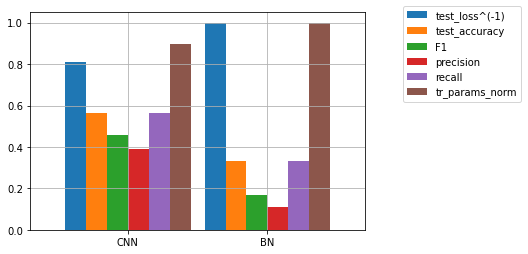

In [ ]:
metrics_to_show = [
                   'test_loss^(-1)',
                   'test_accuracy',
                   'F1',
                   'precision',
                   'recall',
                   'tr_params_norm'
]

plt.figure(figsize = (15, 15))
ax = test_metrics_df.loc[:, metrics_to_show].plot.bar(
    rot = 0,
    width = 0.9
)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.grid()

## Confusion matrices

In [ ]:
models

{'CNN': <CNNModel.CNNModel at 0x2530491e0c8>,
 'BN': <BNModel.BNModel at 0x2530491e188>}

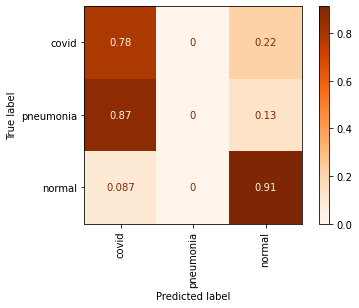

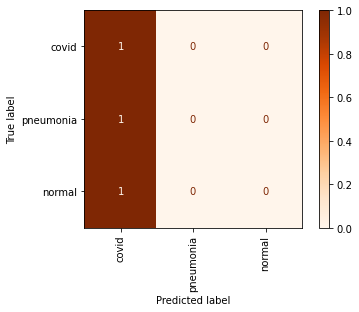

In [ ]:
for m_name, model in models.items():
    test_flow.reset()
    plot_confusion_matrix(
        Y_true = test_flow.classes, 
        Y_pred = model.flow_predict(
            test_flow,
            test_steps
        ),
        class_indices = test_flow.class_indices
    )

## Learning curves

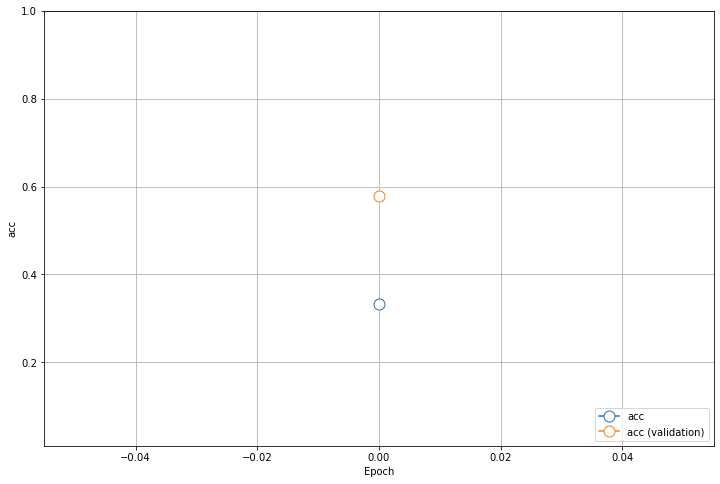

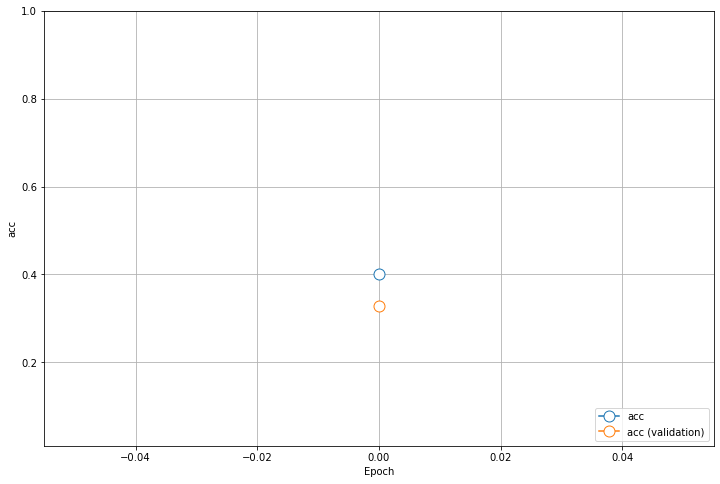

In [ ]:
for m_name, history in histories.items():
    plot_history(
        history = history.history,
        metrics_name = 'acc',
        plot_validation = True
    )

## Layers interpretation

We have:
        3 by 3 kernel, 
        of 3 color channels,
        total: 16 kernels


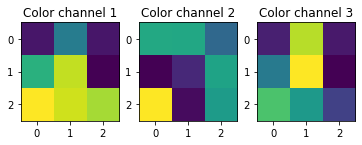

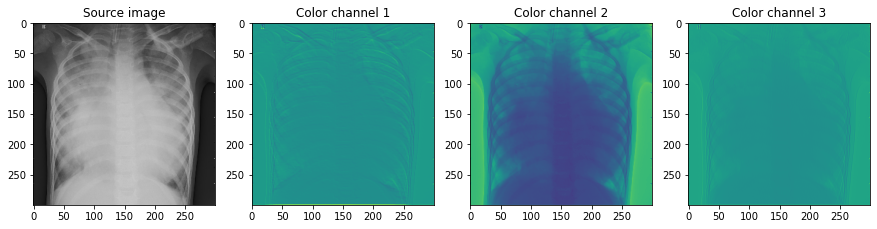

In [ ]:
visualize_kernel_work(
    model = models['CNN'].model, 
    n_layer = 0, 
    n_kernel = 0, 
    image = train_flow[0][0][10],  # 10th image
    label = train_flow[0][1][10],  # 10th image 
    n_color_channels = PreprocessingParameters.n_color_channels[0]
)

We have:
        3 by 3 kernel, 
        of 16 color channels,
        total: 32 kernels


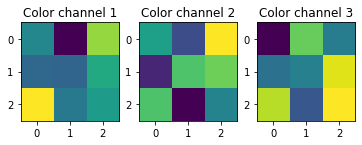

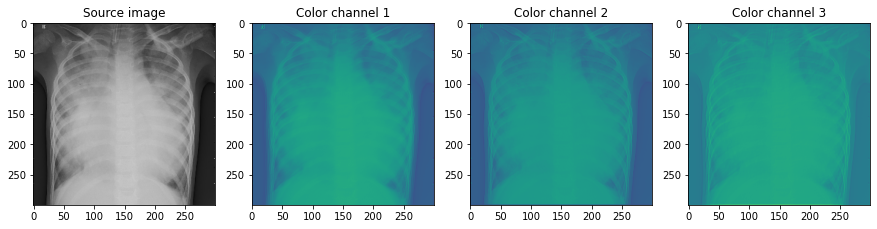

In [ ]:
visualize_kernel_work(
    model = models['CNN'].model, 
    n_layer = 2,
    n_kernel = 0, 
    image = train_flow[0][0][10],  # 10th image
    label = train_flow[0][1][10],  # 10th image 
    n_color_channels = PreprocessingParameters.n_color_channels[0]
)

We have:
        3 by 3 kernel, 
        of 64 color channels,
        total: 256 kernels


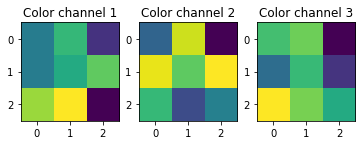

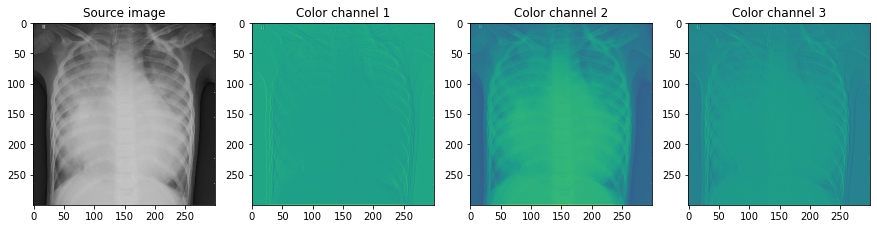

In [ ]:
visualize_kernel_work(
    model = models['CNN'].model, 
    n_layer = 6,
    n_kernel = 0, 
    image = train_flow[0][0][10],  # 10th image
    label = train_flow[0][1][10],  # 10th image 
    n_color_channels = PreprocessingParameters.n_color_channels[0]
)